<a href="https://colab.research.google.com/github/dolevi101/PPKMeans/blob/main/Privacy_Preserving_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tenseal
!pip install numpy
!pip install matplotlib
!pip install fuzzy-c-means

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import copy
import tenseal as ts
import time
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from fcmeans import FCM
import matplotlib.pyplot as plt
import itertools
import random

In [ ]:
def real_kmeans(n_clusters, data):
    print("real_kmeans....")
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data).reshape(-1, 1))
    labels_data = [0]*len(data)
    labels_centers = [1]*len(kmeans.cluster_centers_)
    labels = labels_data + labels_centers
    X = data + list(kmeans.cluster_centers_)  
    print_fig(X, labels, "real kmeans")
    return kmeans.cluster_centers_

In [ ]:
def gmm(n_clusters, data):
    print("gmm...")
    gmm_res = GMM(n_components=n_clusters, random_state=0).fit(np.array(data).reshape(-1, 1))
    labels_data = [0]*len(data)
    labels_centers = [1]*len(gmm_res.means_)
    labels = labels_data + labels_centers
    X = data + list(gmm_res.means_)  
    print_fig(X, labels, "real gmm")
    return gmm_res.means_

In [ ]:
def fuzzy_c_means(n_clusters, data):
    print("fuzzy_c_means...")
    my_model = FCM(n_clusters=n_clusters,m=50) # we use two cluster as an example
    my_model.fit(np.transpose(data)) ## X, numpy array. rows:samples columns:features
    labels_data = [0]*data.shape[1]
    labels_centers = [1]*(my_model.centers.shape[0])
    labels = labels_data + labels_centers
    print(labels)
    print(type(data),type(my_model.centers))
    X = np.concatenate((data,my_model.centers),axis=None)
    print(len(X),len(labels))
    print_fig(X, labels, "real fuzzy_c_means")
    return my_model.centers

In [ ]:
def get_ckks_context():
  # parameters
  #poly_mod_degree = 2**12
  poly_mod_degree = 2**13
  #coeff_mod_bit_sizes = [40, 20, 40]
  coeff_mod_bit_sizes = [35, 25, 25, 25, 25, 25, 25, 25, 25, 35]
  # create TenSEALContext
  context = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  # scale of ciphertext to use
  #context.global_scale = 2 ** 20
  context.global_scale = 2 ** 25
  # this key is needed for doing dot-product operations
  context.generate_galois_keys()
  return context


def get_other_context():
  # parameters
  #poly_mod_degree = 8192
  poly_mod_degree = 16384
  #poly_mod_degree = 32768
  #coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
  coeff_mod_bit_sizes = [60,35,35,35,35,35,35,35,35,35,60]
  #coeff_mod_bit_sizes = [60,50,50,50,50,50,50,50,50,50,50,50,60]
  print("sum of coeff_mod_bit_sizes=", sum(coeff_mod_bit_sizes))
  # create TenSEALContext
  ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  ctx_training.global_scale = 2 ** 35
  ctx_training.generate_galois_keys()
  return ctx_training


def print_fig(X, centers_colors, plot_name):
    # Create a scatter plot
    fig, axs = plt.subplots(nrows=1, ncols=1)
    axs.scatter(X, [0]*len(X), c=centers_colors)
    axs.set_title(plot_name)
    fig.show()

In [ ]:
def max_with_lp(distances, p=20):
  #alpha = ts.plain_tensor(1/p)
  #alpha = 1/p
  #return taylor_series_sqrt_x_plus_1_alpha((x1**p + x2**p+ x3**p+ x4**p) - 1, alpha)
  result_pow = [dist**p for dist in distances]
  return sum(result_pow)
  #return (x1**p + x2**p+ x3**p+ x4**p)


def taylor_series_sqrt_x_plus_1_alpha(x, a):
  sum_elements = 1
  #print("a={}, x={}".format(a,x.data))
  sum_elements += x*a
  sum_elements += 0.5*a*(a-1)*(x**2)
  sum_elements += (1/6)*a*(a-1)*(a-2)*(x**3)
  return sum_elements


def distance_var(a, b, var):
  return ((a-b)**2)*var


def distance(a, b):
  return (a-b)**2


def get_p_value(x, max_val, p,n):
  #approx = approx_to_1_div_x(max_val,n)
  approx = inverse(max_val, n)
  xp = x**p
  #print("xp = {} approx = {}, real = {}".format(xp.decrypt().tolist()[0], approx.decrypt().tolist()[0], (1/(max_val.decrypt().tolist()[0]))))
  #print("x = {}, max_val = {}".format(x, max_val))
  #return xp/max_val
  prob = xp * approx
  return prob
  

#converges only when 0<x<2
def approx_to_1_div_x(x, n):
  #print("x in approx_to_1_div_x is: {}".format(x))
  mul = 1
  for i in range(n):
    mul *= (1+(1-x)**(2**i))
  #print("1/{} = {}".format(x,mul))
  return mul


def inverse(x, n):
    a = 2 - x
    b = 1 - x
    for i in range(n):
        b = b**2
        a = a*(1 + b)
    return a


def normalize_distances(data, centers, n):
  num_of_centers = len(centers)
  num_of_points = len(data)
  dis_before_norm = []
  sum_inv_dis = 0
  for x in data:
      temp_dis_before_norm = []
      for c in centers:
            dis = distance(x, c)
            inv_dis = inverse(dis, n)
            #print("inv_dis = {}".format(inv_dis))
            sum_inv_dis += inv_dis
            temp_dis_before_norm.append(inv_dis)
      dis_before_norm.append(temp_dis_before_norm)
  print(dis_before_norm)
  normalized_dis = []
  for i in range(num_of_points):
    normalized_dis_per_point = []
    for j in range(num_of_centers):
      denominator = inverse(sum_inv_dis, n)
      print("inverse(sum_inv_dis,n) = ",denominator)
      alt_den = 1/sum_inv_dis
      print("1/sum_inv_dis = ",alt_den)
      dis_after_norm = dis_before_norm[i][j] * denominator
      print("dis_after_norm = {}".format(dis_after_norm))
      normalized_dis_per_point.append(dis_after_norm)
    normalized_dis.append(normalized_dis_per_point)

  return normalized_dis


In [ ]:
def distance_from_cen(i,orients,centers):
  dises = []
  for j in range(len(centers)):
      dises.append(abs(centers[j] - centers[i]))
  return dises

In [ ]:
def get_other_cen_calc(cur_i, p_values_sum, orients, centers,data):
  num_d = sum(p_values_sum)
  num_c = len(centers)
  dises = distance_from_cen(cur_i, orients, centers)
  #print(dises)
  res = 0
  for j in range(num_c):
    res += (orients[cur_i][j]/(num_c))*p_values_sum[j]*(1/num_d)*((1-dises[j])/(num_c-1))
  #if (cur_i == 0) or (cur_i == (num_c + 1)):
   # res = 0
  print("for center {} we get {}".format(cur_i,res))
  return res

In [ ]:
def our_kmeans(data, centers, n, p, iterations, stretch_param, orients):
    print("our_kmeans...")
    start = time.time()
    probs, p_values_sum, prev_p_vals = prob_to_be_in_center(data, centers,p,n,1, client_p_vals=None, stretch_param=stretch_param)
    new_centers = [(probs[c_index]/p_values_sum[c_index] - get_other_cen_calc(c_index, p_values_sum, orients, centers, data)) for c_index in range(len(centers))]
    end = time.time()

    print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))
    new_p_val = []
    for i in range(1, iterations):
        start = time.time()
        probs, p_values_sum, prev_p_vals = prob_to_be_in_center(data, new_centers,p,n,i, new_p_val, stretch_param=stretch_param)
        printt = [("probs[c_index] = {} p_values_sum[c_index] = {}  c_index = {}".format(probs[c_index], p_values_sum[c_index], c_index)) for c_index in range(len(centers))]
        print(probs)
        new_centers = [(probs[c_index]/p_values_sum[c_index] - get_other_cen_calc(c_index, p_values_sum, orients, centers, data)) for c_index in range(len(centers))]
        end = time.time()
        print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))
        labels_data = [0]*len(data)
        labels_centers = [1]*len(new_centers)
        labels = labels_data + labels_centers
        X = data + new_centers    
        print_fig(X, labels, "our kmeans")

    labels_data = [0]*len(data)
    labels_centers = [1]*len(new_centers)
    labels = labels_data + labels_centers
    X = data + new_centers    
    print_fig(X, labels, "our kmeans")

In [ ]:
def encrypted_kmeans(data, centers, n, p, iterations, stretch_param):
    print("encrypted_kmeans...")
    context = get_other_context()
    enc_data = [ts.ckks_tensor(context, [item]) for item in data]
    enc_centers = [ts.ckks_tensor(context, [item]) for item in centers]
    
    start = time.time()
    res_probs, res_p_values_sum, res_prev_p_vals = prob_to_be_in_center(enc_data, enc_centers,p,n,1, client_p_vals=None, stretch_param=stretch_param)
    probs, p_values_sum = [item.decrypt().tolist()[0] for item in res_probs], [item.decrypt().tolist()[0] for item in res_p_values_sum]
    new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
    end = time.time()

    print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))
    new_p_val = []

    for i in range(1, iterations):
        start = time.time()
        enc_data = [ts.ckks_tensor(context, [item]) for item in data]
        enc_centers = [ts.ckks_tensor(context, [item]) for item in new_centers]
        res_probs, res_p_values_sum, res_prev_p_vals = prob_to_be_in_center(enc_data, enc_centers,p,n , i, new_p_val,client_p_vals=None, stretch_param=stretch_param)
        probs = [item.decrypt().tolist()[0] for item in res_probs]
        p_values_sum = [item.decrypt().tolist()[0] for item in res_p_values_sum]
        if ((i+1) % stretch_param) == 0:
          prev_p_vals = [item.decrypt().tolist()[0] for item in res_prev_p_vals]
          new_p_val = []
          for row in prev_p_vals:
            new_row = [1 if item==max(row) else 0 for item in row]
            new_p_val.append(new_row)
        new_centers = [probs[c_index]/p_values_sum[c_index] for c_index in range(len(centers))]
        end = time.time()
        print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))

    labels_data = [0]*len(data)
    labels_centers = [1]*len(new_centers)
    labels = labels_data + labels_centers
    X = data + new_centers    
    print_fig(X, labels, "encrypted kmeans")

In [ ]:
def get_vars(data, centers):
  vars = []
  for c in centers:
    dis_per_c = []
    for x in data:
      dis_per_c.append(distance(x, c))
    vars.append((sum(dis_per_c)/len(data)))
  return vars

In [ ]:
def prob_to_be_in_center(data, centers, p,n, use_client_p_val, client_p_vals, stretch_param):
  num_of_centers = len(centers)
  num_of_points = len(data)
  distances_div_k = []
  sum_distance_p_from_point = []
  vars = get_vars(data, centers)
  #print(vars)
  for x in data:
      temp_dis_div_k = []
      temp_sum_div_k = 0
      ##
      dises = []
      for var,c in zip(vars,centers):
            #dis = distance_var(x, c, var)
            dis = distance(x, c)
            dises.append(dis)
            inv = 1/num_of_centers
            dis_div_k = dis * inv
            temp_dis_div_k.append(dis_div_k)
            temp_sum_div_k += dis_div_k
            #print("x = {}, c = {}, dis = {}, dis_div_k = {}, temp_sum_div_k = {}".format(x,c, dis, dis_div_k, temp_sum_div_k))

      ##all_dis_div_k_per_point = [(temp_sum_div_k - item) for item in temp_dis_div_k]
      all_dis_div_k_per_point = [(max(dises) - item+0.05) for item in dises]
      #print("all_dis_div_k_per_point = ",all_dis_div_k_per_point)
      distances_div_k.append(all_dis_div_k_per_point)
      sum_distance_p_from_point.append(sum([item**p for item in all_dis_div_k_per_point]))
    

  distances = distances_div_k

  probs = []
  p_values_sum = []
  prev_p_vals = np.zeros([num_of_points, num_of_centers])
  for i in range(num_of_centers):
    probs_sum = 0
    p_values_sum_per_center = 0
    for j in range(num_of_points):
        p_value = get_p_value(distances[j][i], sum_distance_p_from_point[j], p,n)
        probs_sum += data[j] * p_value
        p_values_sum_per_center += p_value
        if to_print:
          print("@@@@@")
          if is_pp_case:
            print("point: {}, center: {}, p_value: {}".format(data[j].decrypt().tolist()[0], centers[i].decrypt().tolist()[0], p_value.decrypt().tolist()[0]))
          else:
            print("point: {}, center: {}, p_value: {}".format(data[j], centers[i], p_value))
    probs.append(probs_sum)
    p_values_sum.append(p_values_sum_per_center)
    print("finished center {}/{}".format(i+1, num_of_centers))
  return probs, p_values_sum, prev_p_vals


In [ ]:
def get_orient(centers):
  num_c = len(centers)
  orients = [[0]*num_c for _ in range(num_c)]
  for i in range(num_c):
    for j in range(num_c):
      if i == j:
        continue
      orients[i][j] = 1 if centers[i] < centers[j] else -1
  return orients

[[0, 1, 1], [-1, 0, 1], [-1, -1, 0]]
our_kmeans...
@@@@@
point: 0.05, center: 0.2, p_value: 0.9801933839187837
@@@@@
point: 0.1, center: 0.2, p_value: 0.9379897953803172
@@@@@
point: 0.15, center: 0.2, p_value: 0.8506740260433013
@@@@@
point: 0.2, center: 0.2, p_value: 0.7121096733545211
@@@@@
point: 0.21, center: 0.2, p_value: 0.6791377834225812
@@@@@
point: 0.25, center: 0.2, p_value: 0.536470677190965
@@@@@
point: 0.65, center: 0.2, p_value: 0.0016776650696205173
@@@@@
point: 0.7, center: 0.2, p_value: 0.0014151539122322545
@@@@@
point: 0.75, center: 0.2, p_value: 0.0011123299083615728
@@@@@
point: 0.9, center: 0.2, p_value: 0.000415978479752684
@@@@@
point: 0.91, center: 0.2, p_value: 0.00038930199709557613
@@@@@
point: 0.92, center: 0.2, p_value: 0.00036471384370807456
@@@@@
point: 0.9, center: 0.2, p_value: 0.000415978479752684
@@@@@
point: 0.91, center: 0.2, p_value: 0.00038930199709557613
@@@@@
point: 0.92, center: 0.2, p_value: 0.00036471384370807456
@@@@@
point: 0.93, center:

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


array([[0.75],
       [0.96],
       [0.2 ]])

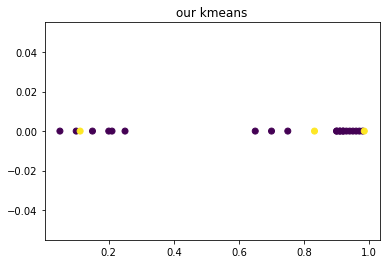

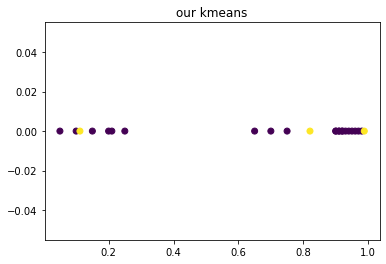

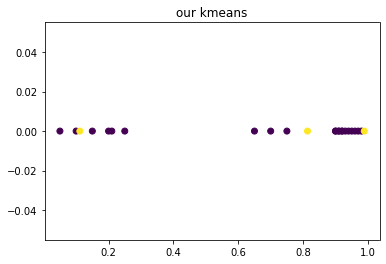

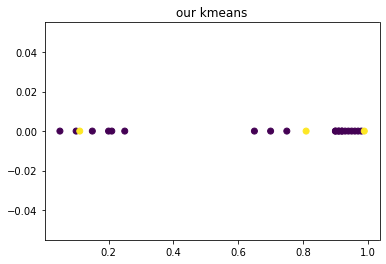

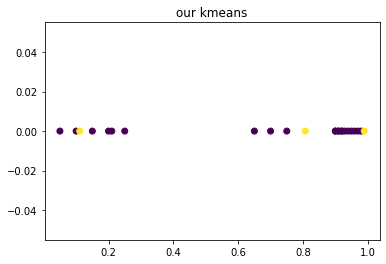

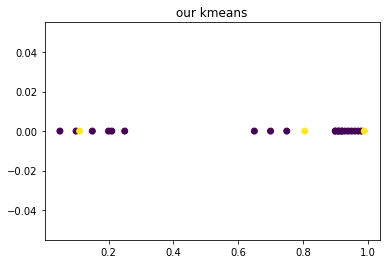

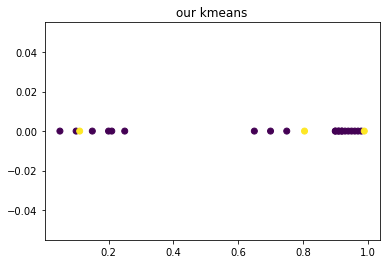

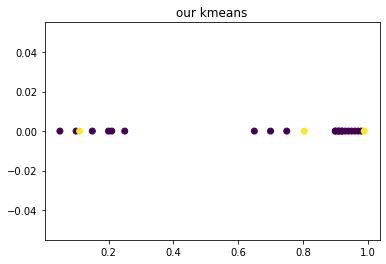

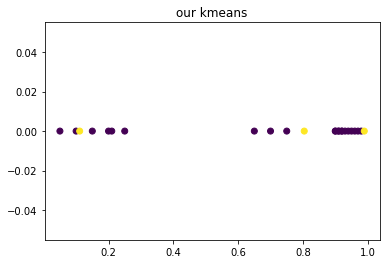

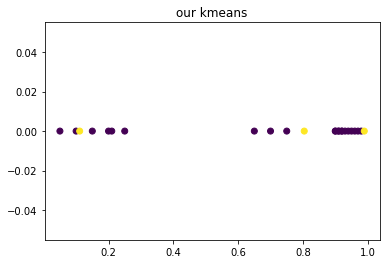

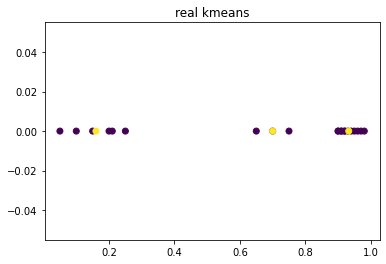

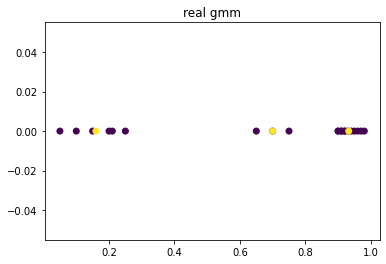

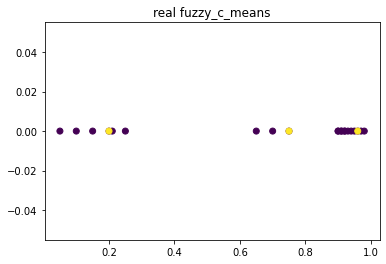

In [ ]:
#data = [0.1, 0.2, 0.5, 0.8, 0.9, 0.15, 0.6, 0.55]
data = [0.05, 0.1,0.15, 0.2, 0.21, 0.25, 0.65, 0.7, 0.75, 0.9, 0.91, 0.92]
data.extend([x/100 for x in list(range(90,99))])
c1 = 0.07
c2 = 0.48
c3 = 0.75
initial_centers = [0.2, 0.8, 0.81]
orients = get_orient(initial_centers)
print(orients)
n=3
#p must be even
p=3
iterations = 10
to_print = True
stretch_param = 100

#data = static_data

is_pp_case = False
our_kmeans(data, initial_centers, n, p, iterations, stretch_param, orients)
real_kmeans(len(initial_centers), data)
gmm(len(initial_centers), data)
print((np.array(data).shape))
fuzzy_c_means(len(initial_centers), (np.asarray(data)).reshape(1,-1))
#is_pp_case = True
#encrypted_kmeans(data, initial_centers, n, p, iterations)